# Project One Executive Summary

## Governance Networks and Structural Influence in New York City Nonprofits

This study examines how nonprofit organizations in New York City are connected through shared board members and whether Health Organization classified nonprofits occupy more influential positions within that governance structure.

Using publicly available IRS data, I constructed a board interlock network of 27,022 NYC nonprofits. In this network, two organizations are connected if they share at least one board member. These shared leadership relationships form a governance structure that reflects how influence, information, and strategic coordination may circulate across organizations.

After building the network, I determined that:

- 8,007 nonprofits were connected through shared board memberships.
- These organizations formed 373 separate clusters.
- One large governance core contained 7,119 interconnected nonprofits.

To evaluate structural position, I measured two types of centrality:

- **Degree Centrality** — the number of direct board-sharing connections an organization has.
- **Eigenvector Centrality** — a measure of influence that gives greater weight to connections with already influential organizations.

Eigenvector centrality captures structural influence within the governance network, not financial size or mission importance, but position within leadership circles.

I then compared Health nonprofits to Non-Health nonprofits to determine whether the Health sector holds a structurally dominant position.

### Key Findings

- Influence in the NYC nonprofit governance network is highly concentrated.
- Most nonprofits have relatively few connections and low structural influence.
- A small group of organizations occupies highly central positions.
- There is no statistically significant difference between Health and Non-Health nonprofits in terms of connectivity or influence.

In sum, while nonprofit governance in NYC exhibits strong structural concentration, that concentration is not sector-driven. Health nonprofits are integrated into the broader governance core but do not dominate it.

### Broader Implications

These findings suggest that structural influence within nonprofit governance networks may be driven more by other factors, such as organizational prominence, civic engagement, and cross-sector connectivity, rather than by sector classification alone. This is an area for future research.

Understanding governance networks in this way provides a framework for evaluating leadership influence, strategic positioning, and institutional interconnectedness in complex nonprofit ecosystems. Another area for future reseach to explore the effect in other cities which have complex nonprofit ecosystems.

## Coding Architecture

I designed the code blocks below in compartmentalized modules for easy readability and to be able to reuse them in other projects.

### Model 1: Preparing the Tools

In this section, I loaded the software libraries needed to complete my analysis.

In sum, these tools allow me to:

- Work with large data tables.
- Perform calculations and statistical tests.
- Build and analyze a network of shared board members.
- Create visual charts to help interpret results.

Even though some of these libraries are basic and repeatedly used in many projects, such as pandas, I commented out each library to understand their functions.

In [1]:
# Module 1: Import Libraries

import pandas as pd                  # Used to work with tables of data (like Excel sheets in Python)

import numpy as np                   # Used for numerical calculations and handling arrays of numbers

import igraph as ig                  # Used to build and analyze the nonprofit network structure

from itertools import combinations   # Used to create all possible pairs of nonprofits that share a board member

from scipy.stats import ttest_ind    # Used to statistically compare Health vs Non-Health nonprofits

import seaborn as sns                # Used to create professional statistical visualizations

import matplotlib.pyplot as plt      # Used to control chart formatting and display plots

import textwrap                      # Used to wrap long organization names so they fit on charts

### Module 2: Loading the Data

In this module, I load two datasets:

1. A dataset containing nonprofit organization details such as name and location.
2. A dataset listing board members and the organizations they serve.

The second dataset serves as the foundation for my network analysis. It informs me which nonprofits are connected through shared leadership.

When extracting data from the IRS files, I encountered a major issue. My analysis begins with extracting data from **728,719 tax returns** and **3,646,072  board-member relationships**. Every time I wanted to restart a kernel, I would have to extract the same data over and over. Each extraction took about one hour. After much research, I found that converting the raw IRS data into Parquet files would significantly speed up the analysis, reduce memory usage, and make it more reproducible. I stored the Parquet files in my local drive.

For documentation purposes, I am outlining the benefits of using the Parquet format for this large dataset. 

**1. Faster Loading.**
Parquet files load significantly faster than CSV files because they are stored in a compressed, binary format optimized for analytics.

**2. Smaller File Size.**
Parquet automatically compresses data, reducing storage requirements without losing information.

**3. Efficient Column Access.**
Parquet is column-based. This means I can load only the columns I need, rather than reading an entire dataset into memory.

**4. Reproducibility.**
By saving cleaned datasets as Parquet files, I avoided repeatedly processing raw IRS data. This ensures that every time the notebook runs, it starts from a consistent, structured dataset. This I found super important!

**5. Better Performance for Network Analysis.**
Because network construction involves filtering, grouping, and merging large datasets, Parquet improves performance and reduces memory strain during those operations.

I also printed the size of each dataset to understand the scale of the analysis.

In [2]:
# Module 2: Loading the data

df_meta = pd.read_parquet("irs_meta_raw.parquet")
df_board = pd.read_parquet("irs_board_raw.parquet")

# Print the size of the raw datasets.
print("Metadata rows:", len(df_meta))
print("Board relationships:", len(df_board))

Metadata rows: 728719
Board relationships: 3646072


### Module 3: Isolating NYC Nonprofits and Identifying Health Organizations

In this section, I created a subset of only nonprofits located in New York City. I then merge official nonprofit classification codes published by the IRS. These are known as **[National Taxonomy of Exempt Entities (NTEE codes)](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://www.irs.gov/pub/irs-tege/p4838.pdf)** that indicate the type of organization. The NTEE codes can also be found at the **[National Center for Charitable Statistics](https://urbaninstitute.github.io/nccs-legacy/ntee/ntee.html).** A **[detailed history of NTEE codes and their definitions](https://urbaninstitute.github.io/nccs-legacy/ntee/ntee-history.html#data)** are also available.

Using those classifications, I grouped nonprofits into two categories:

- Health
- Non-Health

Grouping them into two categories allowed me to later compare whether Health nonprofits occupy more influential positions within the governance network.

Out of the 27,022 NYC nonprofits, **1,399 classified as Health** and **25,623 were classified as Non-Health**.
Sector_Group
Non-Health    25623
Health         1399

In [3]:
# Module 3: Filtering for NYC nonprofit and classifying the sector

# I filtered nonprofits located only in NYC by Zip Codes, based on their 3-digit prefix.
nyc_zip_prefixes = ("100","101","102","103","104","110","111","112","113","114","116")

# I then converted the Zip Codes to strings and kept only the first 5 digits.
# I needed to remove Zip+4 extensions to have consistent formatting.
df_meta["Org_Zip"] = df_meta["Org_Zip"].astype(str).str[:5]

# I then kept only nonprofits whose Zip Code starts with an NYC prefix.
# I excluded missing Zip Codes by setting 'na=False'.
# I used '.copy()' to prevent an accidental modification of the original dataframe.
df_nyc = df_meta[
    df_meta["Org_Zip"].str.startswith(nyc_zip_prefixes, na=False)
].copy()

# I then merged the official NTEE Codes by loading only the EIN and NTEE classification columns from the IRS file.
# I used 'dtype=str' to make sure that the EINs were treated as text and not numbers.
bmf = pd.read_csv("eo1.csv", dtype=str)[["EIN","NTEE_CD"]]

# I then had to make sure that EIN values were exactly 9 digits by adding leading zeros where needed.
# If I did not add leading zeros where needed, I would have mismatches when merging.
bmf["EIN"] = bmf["EIN"].str.zfill(9)

# I then made sure that the NYC dataset had consistent 9-digit formatting for EINs.
df_nyc["EIN"] = df_nyc["EIN"].astype(str).str.zfill(9)

# I then merged the NTEE classification data into the NYC nonprofit dataset.
# I used 'on="EIN"' to matche nonprofits by their tax ID.
# I used 'how="left"' to keep all NYC nonprofits, even if classification is missing.
df_nyc = df_nyc.merge(bmf, on="EIN", how="left")


# In the next steps, I classified to categories: Health vs Non-Health

# I extracted the first letter of the NTEE code. The first letter represents the nonprofit’s major sector.
df_nyc["NTEE_Major"] = df_nyc["NTEE_CD"].str[0]

# I then defined which NTEE major letters correspond to Health classified nonprofits.
# The letters represent different health-related categories in the IRS system.
health_letters = {"E","F","G","H"}

# I then created a new column that labels each nonprofit as either:
# "Health" if its NTEE major letter is in our health set, "Non-Health" otherwise
# I used '.isin()' to  check membership in the health set.
# I used '.map()' to convert True/False into readable labels.
df_nyc["Sector_Group"] = df_nyc["NTEE_Major"].isin(health_letters).map({
    True: "Health",
    False: "Non-Health"
})

# I printed the total number of NYC nonprofits remaining after filtering.
print("NYC nonprofits:", len(df_nyc))

# I then counted how many nonprofits fall into each sector group, verifying correct classification.
print(df_nyc["Sector_Group"].value_counts())

NYC nonprofits: 27022
Sector_Group
Non-Health    25623
Health         1399
Name: count, dtype: int64


### Module 4: Building the Board Interlock Network

In this section, I constructed the NYC nonprofit governance network using shared board memberships.

Two nonprofits are connected if they share at least one board member. This produces an undirected graph representing leadership interlocks across organizations.

The constructed NYC governance network exhibits the following structure:

- **Connected nonprofits (nodes):** 8,007  
- **Shared-board relationships (edges):** 26,814  
- **Separate governance clusters (components):** 373  
- **Largest governance core size:** 7,119 nonprofits  

Although 27,022 nonprofits operate in NYC, only 8,007 are connected through shared board memberships. Governance connectivity is therefore concentrated within a single dominant cluster containing 7,119 nonprofits.

This suggests that leadership influence circulates primarily within a densely interconnected institutional core rather than being evenly distributed across all nonprofits.


In [4]:
# Module 4: Build NYC Board Interlock Network

# We keep only board records for NYC nonprofits
df_board_nyc = df_board[df_board["EIN"].isin(df_nyc["EIN"])]

# For each board member, we collect the list of nonprofits they serve
grouped = df_board_nyc.groupby("BoardMember")["EIN"].apply(list)

# We will create connections between nonprofits that share a board member
edges = []

for ein_list in grouped:
    # We only create connections if a board member serves on 2–20 boards
    # (This avoids unrealistic massive board memberships)
    if 1 < len(ein_list) <= 20:
        edges.extend(combinations(ein_list, 2))

# Convert connections into a dataframe
edge_df = pd.DataFrame(edges, columns=["source","target"]).drop_duplicates()

# Build the network graph
g = ig.Graph.DataFrame(edge_df, directed=False, use_vids=False)

# Print basic network structure
print("Nodes:", g.vcount())
print("Edges:", g.ecount())
print("Components:", len(g.components()))
print("Largest component size:", max(g.components().sizes()))

Nodes: 8007
Edges: 26814
Components: 373
Largest component size: 7119


### Module 5: Focusing on the Largest Governance Cluster

Because centrality measures are only meaningful within connected components, I restricted further analysis to the largest connected subgraph.

- **Original connected nonprofits: 8,007** 
- **Nonprofits in the largest governance core: 7,119**

Approximately **89% of connected nonprofits belong to the primary governance core**, indicating strong structural consolidation of board interlocks within NYC.

This core becomes the focus of all subsequent centrality and influence analyses.


In [5]:
# Module 5: Largest Connected Component

# Break the network into its separate clusters
components = g.components()

# Identify which cluster is the largest one
largest_component_index = np.argmax(components.sizes())

# Extract only the largest cluster for analysis
g_largest = components.subgraphs()[largest_component_index]

# Show how many nonprofits were in the original network
print("Original nodes:", g.vcount())

# Show how many nonprofits remain in the main governance core
print("Largest component nodes:", g_largest.vcount())

Original nodes: 8007
Largest component nodes: 7119


### Module 6: Measuring Connections and Influence

I computed two structural measures:

- **Degree Centrality** — number of direct board-sharing connections  
- **Eigenvector Centrality** — influence weighted by the influence of connected organizations  

Degree centrality captures direct connectivity, while eigenvector centrality captures embedded structural influence.

A preliminary inspection shows:

- Degree values range from very low (1–5 connections) to extremely high (over 140 connections).
- Eigenvector centrality is highly skewed, with a small number of organizations approaching values near 1.0.

This suggests substantial inequality in structural influence.

In [6]:
# Module 6: Centrality Measures

# Count how many nonprofits each organization directly connects to
g_largest.vs["Degree"] = g_largest.degree()

# Measure influence based on connections to influential organizations
g_largest.vs["Eigenvector"] = g_largest.eigenvector_centrality()

# Convert network results into a structured table
df_cent = pd.DataFrame({
    "EIN": g_largest.vs["name"],
    "Degree": g_largest.vs["Degree"],
    "Eigenvector": g_largest.vs["Eigenvector"]
})

# Attach organization names and sector labels
df_cent = df_cent.merge(
    df_nyc[["EIN","Sector_Group","Nonprofit_Org"]]
        .drop_duplicates(subset="EIN"),
    on="EIN",
    how="left"
)

# Preview the influence table
print(df_cent.head())

         EIN  Degree  Eigenvector Sector_Group  \
0  042280806       2     0.000050   Non-Health   
1  042133248      11     0.000805   Non-Health   
2  042103701       7     0.000426   Non-Health   
3  113600385       2     0.002482   Non-Health   
4  453533828       3     0.002738   Non-Health   

                             Nonprofit_Org  
0      HILLCREST PARK CEMETERY ASSOCIATION  
1  URBAN LEAGUE OF GREATER SPRINGFIELD INC  
2           AMERICAN INTERNATIONAL COLLEGE  
3          DOWNSTATE TECHNOLOGY CENTER INC  
4                               BIOBAT INC  


### Module 7: Testing for Sector Differences

Here, I tested whether Health nonprofits differ from Non-Health nonprofits in structural positioning using Welch’s t-test (due to high inequality).

### Degree Centrality

- **p-value: 0.498**  
- **Result:** Not statistically significant  

### Eigenvector Centrality

- **p-value: 0.325**  
- **Result:** Not statistically significant  

## Interpretation

There is no statistically significant difference between Health and Non-Health nonprofits in:

- Number of direct board interlocks  
- Structural influence within the governance network  

Sector classification alone does not explain governance centrality within NYC’s nonprofit ecosystem.


In [7]:
# Module 7: Welch T-Test to Compare Groups

# Separate Health and Non-Health nonprofits
health = df_cent[df_cent["Sector_Group"] == "Health"]
non_health = df_cent[df_cent["Sector_Group"] == "Non-Health"]

# Test whether the average number of connections differs
t_deg, p_deg = ttest_ind(
    health["Degree"].dropna(),
    non_health["Degree"].dropna(),
    equal_var=False
)

# Test whether influence differs
t_eig, p_eig = ttest_ind(
    health["Eigenvector"].dropna(),
    non_health["Eigenvector"].dropna(),
    equal_var=False
)

# Print statistical results
print(f"Degree: t = {t_deg:.3f}, p = {p_deg:.4f}")
print(f"Eigenvector: t = {t_eig:.3f}, p = {p_eig:.4f}")

Degree: t = 0.678, p = 0.4982
Eigenvector: t = -0.985, p = 0.3252


### Module 8: Visual Comparison by Sector

I created two boxplots to visually compare the Health and Non-Health nonprofit sectors. The boxplots revealed:

The top boxplot shows Eigenvector Centrality (influence) by sector.
The bottom boxplot shows the Degree Centrality (number of board connections) by sector.

Each dot represents one nonprofit.

The boxes show the typical range, and the dots above them indicate organizations that are unusually high compared to the rest. The flatness of the boxes shows that the eigenvevector scores are relatively low in NYC nonprofits. The boxplots can be summarized as:

- Highly skewed distributions  
- Large numbers of low-centrality organizations  
- Extremely high-centrality outliers in both sectors  

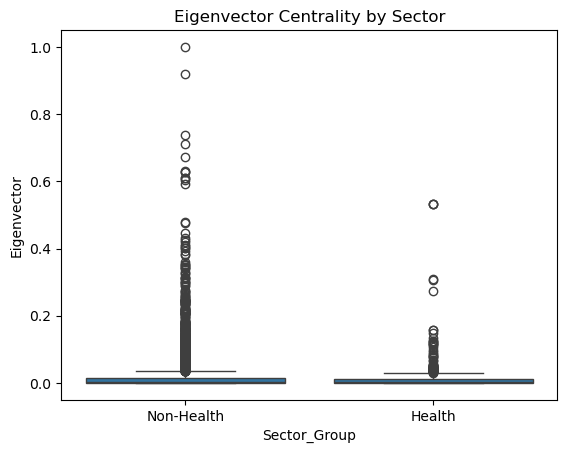

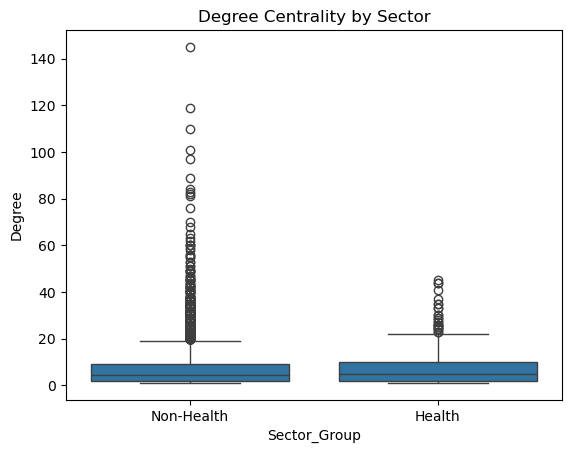

In [8]:
# Module 8: Visual Comparisons of Centrality by Sector

# Plot influence distribution by sector
sns.boxplot(data=df_cent, x="Sector_Group", y="Eigenvector")
plt.title("Eigenvector Centrality by Sector")
plt.show()

# Plot connection counts by sector
sns.boxplot(data=df_cent, x="Sector_Group", y="Degree")
plt.title("Degree Centrality by Sector")
plt.show()

## Module 9: Examining the Shape of Influence Distribution

I ran a Log-Transformed Eigenvector Centrality Distribution to examine how influence is spread out across all NYC nonprofits. Because most eigenvector scores are very small, I need to use a log transformation to spread them out to actually see the pattern.

After log-transformation:

- Most nonprofits cluster near zero  
- A small number exhibit disproportionately high influence  
- Health and Non-Health distributions overlap substantially  

This pattern shows a strongly right-skewed distribution, revealing the structural inequality of influence. It assumes that influence is network-driven rather than sector-driven.

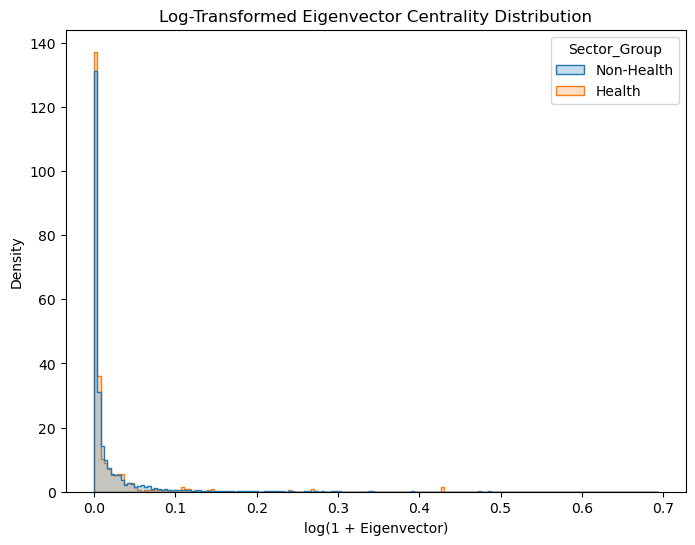

In [9]:
# Module 9: Log Scale Transformation

plt.figure(figsize=(8,6))

sns.histplot(
    data=df_cent,
    x=np.log1p(df_cent["Eigenvector"]),
    hue="Sector_Group",
    element="step",
    stat="density",
    common_norm=False
)

plt.title("Log-Transformed Eigenvector Centrality Distribution")
plt.xlabel("log(1 + Eigenvector)")
plt.show()

## Module 10: Relationship Between Connections and Influence

I ran a scatterplot to examine the relationship between the number of connections (degree centrality) and structural influence (eigenvector centrality).

The horizontal axis (Degree Centrality) shows how many other nonprofits it shares board members with. The higher the X-axis, the more board connections.

The vertical axis (Eigenvector Centrality) shows how influential that nonprofit is in the overall governance network.The higher the y-axis, the more influential in the leadership.

The scatterplot revealed that there is: 

- A positive but nonlinear relationship  
- Organizations with a higher degree tend to have higher influence  
- A high degree does not guarantee high eigenvector centrality  

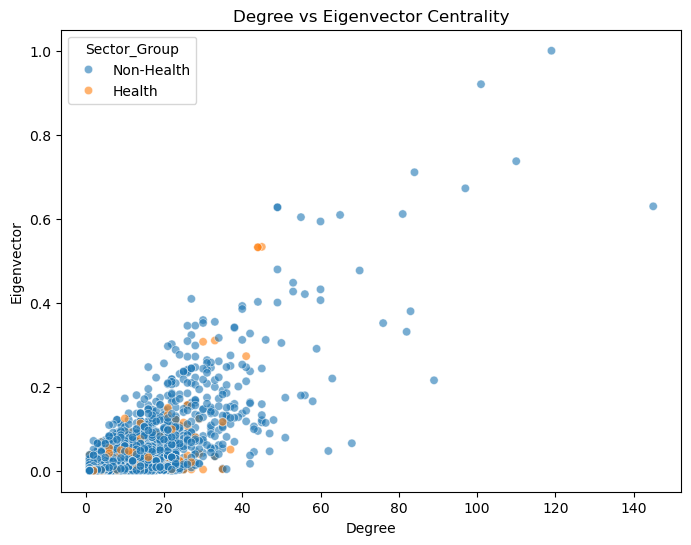

In [10]:
# Module 10: Degree vs Eigenvector Scatter Plot

plt.figure(figsize=(8,6))

sns.scatterplot(
    data=df_cent,
    x="Degree",
    y="Eigenvector",
    hue="Sector_Group",
    alpha=0.6
)

plt.title("Degree Centrality vs Eigenvector Centrality")
plt.show()

### Module 11A, 11B, 11C: Identifying the Most NYC Influential Nonprofits

I ranked the NYC nonprofits by eigenvector centrality to identify the organizations occupying the most structurally influential positions within the NYC governance network. Interestingly, none of the Health Nonprofit Organizations ranked in the top 10. 

The highest eigenvector score assigned to the Real Estate Board of New York equals **1.000**, reflecting normalization to the most central node in the network. For 2022, the nonprofit organization maintained **119 direct governance connections**, indicating an unusually high level of embeddedness within the nonprofit leadership core.

The analysis reveals several structural patterns:

- The most influential organizations are overwhelmingly **Non-Health nonprofits**.
- Judging from the names of the organizations, influence is concentrated among major civic, economic, cultural, tourism, and labor institutions.
- High eigenvector centrality does not automatically imply the highest influence, but the top organizations tend to combine high connectivity with high eigenvector centrality.
- At least in the top nonprofit organizations, governance centrality appears to reflect **cross-sector civic embeddedness**, rather than dominance by a single institutional category.

To further evaluate structural dominance, I examined the most influential organization. The **Real Estate Board of New York** ranked number one. Its top influential connections include The Partnership for New York City and Lincoln Center. The only top 10 Health Nonprofit Organization to be connected to the Real Estate Board of New York is the **New York Society for the Relief of the Ruptured and Crippled**.

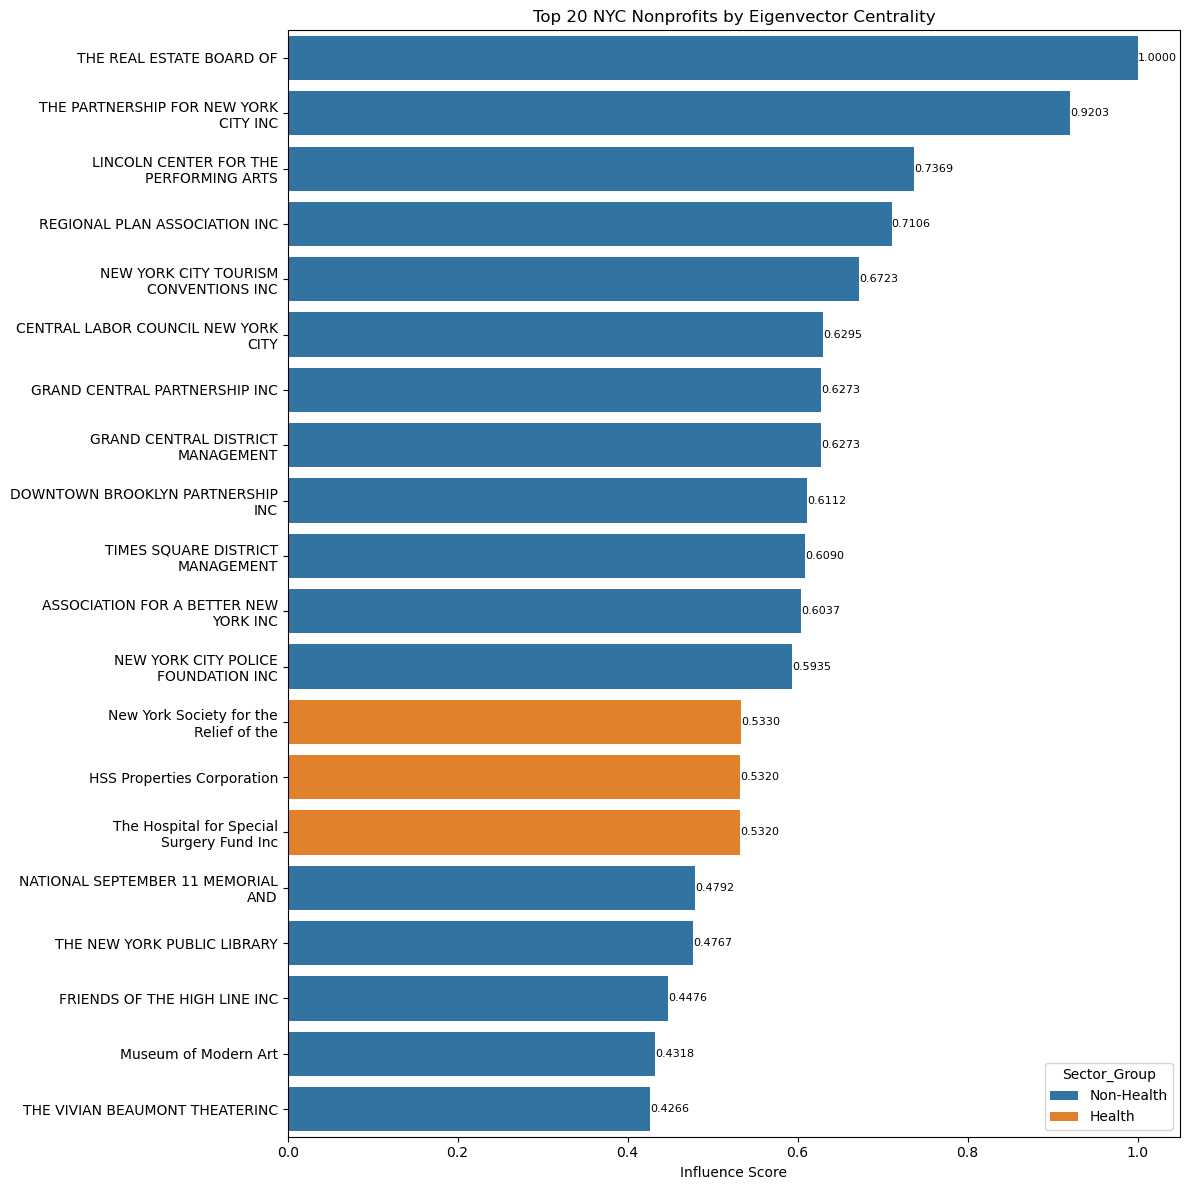

In [11]:
# Module 11A: 20 Top Most Influential

df_cent.sort_values("Eigenvector", ascending=False)[
    ["Nonprofit_Org","Eigenvector","Degree","Sector_Group"]
].head(10)

# Sort nonprofits from most influential to least
top20 = df_cent.sort_values("Eigenvector", ascending=False).head(20)

# Wrap long organization names so they fit on the chart
top20["Wrapped_Name"] = top20["Nonprofit_Org"].apply(
    lambda x: "\n".join(textwrap.wrap(x, width=30))
)

plt.figure(figsize=(12,12))

ax = sns.barplot(
    data=top20,
    x="Eigenvector",
    y="Wrapped_Name",
    hue="Sector_Group",
    dodge=False
)

# Add influence score next to each bar
for i, row in top20.iterrows():
    ax.text(
        row["Eigenvector"] + 0.0001,
        list(top20.index).index(i),
        f"{row['Eigenvector']:.4f}",
        va='center',
        fontsize=8
    )

plt.title("Top 20 NYC Nonprofits by Eigenvector Centrality")
plt.xlabel("Influence Score")
plt.ylabel("")
plt.tight_layout()
plt.show()

In [13]:
# Module 11B: Tabling the Top 10
df_cent.sort_values("Eigenvector", ascending=False)[
    ["Nonprofit_Org","Eigenvector","Degree","Sector_Group"]
].head(10)

,Nonprofit_Org,Eigenvector,Degree,Sector_Group
126,THE REAL ESTATE BOARD OF,1.000000,119,Non-Health
319,THE PARTNERSHIP FOR NEW YORK CITY INC,0.920275,101,Non-Health
314,LINCOLN CENTER FOR THE PERFORMING ARTS,0.736925,110,Non-Health
326,REGIONAL PLAN ASSOCIATION INC,0.710635,84,Non-Health
581,NEW YORK CITY TOURISM CONVENTIONS INC,0.672350,97,Non-Health
1279,CENTRAL LABOR COUNCIL NEW YORK CITY,0.629530,145,Non-Health
166,GRAND CENTRAL PARTNERSHIP INC,0.627260,49,Non-Health
165,GRAND CENTRAL DISTRICT MANAGEMENT,0.627260,49,Non-Health
484,DOWNTOWN BROOKLYN PARTNERSHIP INC,0.611225,81,Non-Health
907,TIMES SQUARE DISTRICT MANAGEMENT,0.609030,65,Non-Health


In [15]:
# Module 11C: Finding the Real Estate Board of New York (REBNY) Neighbors' Connections

# Find the EIN for Real Estate Board of NY
rebny_ein = df_nyc[
    df_nyc["Nonprofit_Org"].str.contains("THE REAL ESTATE BOARD OF", case=False, na=False)
]["EIN"].iloc[0]

print("REBNY EIN:", rebny_ein)

# Ensure g_largest exists
assert 'g_largest' in globals(), "You must build the network and g_largest first."

# Get index of REBNY in g_largest
rebny_idx = g_largest.vs.find(name=rebny_ein).index

# List direct neighbors
neighbor_indices = g_largest.neighbors(rebny_idx)
neighbor_eins = list(set(
    g_largest.vs[i]["name"] for i in neighbor_indices
))

print("REBNY directly connected to:", len(neighbor_eins), "organizations")

REBNY EIN: 131201480
REBNY directly connected to: 119 organizations


In [22]:
# ============================================================
# Module 11E: Top 10 Most Influential REBNY Neighbors
# Ranked by Eigenvector Centrality
# ============================================================

# Ensure required objects exist
assert 'df_cent' in globals(), "Run centrality module first."
assert 'neighbor_eins' in globals(), "Run REBNY neighbor extraction first."

# Filter centrality table to only REBNY neighbors
rebny_neighbors_cent = df_cent[
    df_cent["EIN"].isin(neighbor_eins)
].copy()

# Rank by eigenvector centrality (descending)
top10_neighbors_eigen = (
    rebny_neighbors_cent
    .sort_values("Eigenvector", ascending=False)
    .head(10)
    .reset_index(drop=True)
)

# Add rank column for clean presentation
top10_neighbors_eigen["Rank"] = top10_neighbors_eigen.index + 1

# Display results
top10_neighbors_eigen[
    ["Rank", "Nonprofit_Org", "Eigenvector", "Degree", "Sector_Group"]
]

,Rank,Nonprofit_Org,Eigenvector,Degree,Sector_Group
0,1,THE PARTNERSHIP FOR NEW YORK CITY INC,0.920275,101,Non-Health
1,2,LINCOLN CENTER FOR THE PERFORMING ARTS,0.736925,110,Non-Health
2,3,REGIONAL PLAN ASSOCIATION INC,0.710635,84,Non-Health
3,4,NEW YORK CITY TOURISM CONVENTIONS INC,0.672350,97,Non-Health
4,5,GRAND CENTRAL PARTNERSHIP INC,0.627260,49,Non-Health
5,6,GRAND CENTRAL DISTRICT MANAGEMENT,0.627260,49,Non-Health
6,7,DOWNTOWN BROOKLYN PARTNERSHIP INC,0.611225,81,Non-Health
7,8,TIMES SQUARE DISTRICT MANAGEMENT,0.609030,65,Non-Health
8,9,ASSOCIATION FOR A BETTER NEW YORK INC,0.603719,55,Non-Health
9,10,New York Society for the Relief of the,0.533026,45,Health
